# Disbursement and Expenditure Transactions vs Flow Type

Pipeline to extract all disbursement and expenditure transactions in IATI data with associated Flow types\.

# Setup

Connecting to https://iati\-tables\.codeforiati\.org/  to pull data\.

In [23]:
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import Counter

sns.set_context('notebook')

#start noteql session
import noteql
# Restart postgres to make sure any existing connections get dropped
!sudo service postgresql restart
session = noteql.Session(datasette_url='https://datasette.tables.iatistandard.org/iati.json', connect_args={'connect_timeout': 1000})

postgresql: unrecognized service
Using db connection https://datasette.tables.iatistandard.org/iati.json 


Read in CRS flow type codelist

In [2]:
#read codelist
flowtype = pd.read_csv("FlowType.csv")
flowtype['code'] = flowtype['code'].astype(str)
flowtype

,code,name,description,category,url,status
0,10,ODA,Official Development Assistance,NaN,NaN,active
1,20,OOF,Other Official Flows,NaN,NaN,withdrawn
2,21,Non-export credit OOF,"Other Official Flows, excl. export credits",NaN,NaN,active
3,22,Officially supported export credits,Officially supported export credits. Covers bo...,NaN,NaN,active
4,30,Private Development Finance,Financing by civil society organisations (NGOs...,NaN,NaN,active
5,35,Private Market,Private long-term (i.e. over one-year maturity...,NaN,NaN,withdrawn
6,36,Private Foreign Direct Investment,Private Foreign Direct Investment,NaN,NaN,active
7,37,Other Private flows at market terms,Private long-term (i.e. over one-year maturity...,NaN,NaN,active
8,40,Non flow,"e.g. GNI, ODA%GNI, Population etc",NaN,NaN,active
9,50,Other flows,e.g. non-ODA component of peacebuilding operat...,NaN,NaN,active


# Download data

## All outgoing disbursement transactions

Where: 

-  date is not null

- year is 2010 to 2024 

- iati\-identifier is not null

In [29]:
%%nql SHOW disbursements=DF

SELECT
    iatiidentifier, 
    reportingorg_ref,
    transactiontype_code, 
    transactiontype_codename, 
    SUBSTRING(transactiondate_isodate, 1, 4) as 'year',
    SUM(value_usd) as 'sum_value_usd',
    flowtype_code, 
    flowtype_codename
FROM trans
WHERE 
   transactiontype_code=3
   AND (transactiondate_isodate is not null and transactiondate_isodate != "")
   AND (CAST(SUBSTRING(transactiondate_isodate, 1, 4) as numeric) > 2009 AND
   CAST(SUBSTRING(transactiondate_isodate, 1, 4) as numeric) < 2025) AND
    ("iatiidentifier" is not null and "iatiidentifier" != "")
GROUP BY iatiidentifier, reportingorg_ref, transactiontype_code, transactiontype_codename, 
        SUBSTRING(transactiondate_isodate, 1, 4),flowtype_code, flowtype_codename


,iatiidentifier,reportingorg_ref,transactiontype_code,transactiontype_codename,year,sum_value_usd,flowtype_code,flowtype_codename
0,\n\t\t\tUS-501c3-522318905-SG-871711214599\n\t\t,US-501c3-522318905,3,Disbursement,2013,4.806148e+03,,
1,\n\t\t\tUS-501c3-522318905-SG-872381001040\n\t\t,US-501c3-522318905,3,Disbursement,2010,1.311372e+07,,
2,\n\t\t\tUS-501c3-522318905-SG-872381026532\n\t\t,US-501c3-522318905,3,Disbursement,2013,1.566400e+04,,
3,\n\t\t\tUS-501c3-522318905-SG-872381072938\n\t\t,US-501c3-522318905,3,Disbursement,2012,9.749000e+03,,
4,\n\t\t\tUS-501c3-522318905-SG-872381113014\n\t\t,US-501c3-522318905,3,Disbursement,2013,9.255000e+03,,
...,...,...,...,...,...,...,...,...
855407,us-ein-522044704-NewVaccinesForTB,US-EIN-522044704,3,Disbursement,2013,1.677010e+05,,
855408,us-ein-522044704-NewVaccinesForTB,US-EIN-522044704,3,Disbursement,2014,1.663706e+06,,
855409,us-ein-522044704-NewVaccinesForTB,US-EIN-522044704,3,Disbursement,2016,1.233533e+06,,
855410,us-ein-522044704-NewVaccinesForTB,US-EIN-522044704,3,Disbursement,2017,6.775694e+05,,


Check dates are correct \- should be 2010 onwards

In [4]:
set(disbursements['year'])

{2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024}

## All outgoing expenditure transactions

Where: 

- date is not null

- year is 2010 to 2024 

- iati\-identifier is not null

In [5]:
%%nql SHOW expenditures=DF

SELECT
    iatiidentifier, 
    reportingorg_ref,
    transactiontype_code, 
    transactiontype_codename, 
    SUBSTRING(transactiondate_isodate, 1, 4) as 'year',
    SUM(value_usd) as 'sum_value_usd',
    flowtype_code, 
    flowtype_codename
FROM trans
WHERE 
   transactiontype_code=4
   AND (transactiondate_isodate is not null and transactiondate_isodate != "")
   AND (CAST(SUBSTRING(transactiondate_isodate, 1, 4) as numeric) > 2009 AND
   CAST(SUBSTRING(transactiondate_isodate, 1, 4) as numeric) < 2025) AND
    ("iatiidentifier" is not null and "iatiidentifier" != "")
GROUP BY iatiidentifier,reportingorg_ref, transactiontype_code, transactiontype_codename, 
        SUBSTRING(transactiondate_isodate, 1, 4),flowtype_code, flowtype_codename

,iatiidentifier,reportingorg_ref,transactiontype_code,transactiontype_codename,year,sum_value_usd,flowtype_code,flowtype_codename
0,\n\t\t\tUS-501c3-522318905-SG-NGA/000093\n\t\t,US-501c3-522318905,4,Expenditure,2011,164000.00,,
1,\n\t\t\tUS-501c3-522318905-SG-NGA/000100\n\t\t,US-501c3-522318905,4,Expenditure,2011,4500000.00,,
2,\n\t\t\tUS-501c3-522318905-SG-NGA/000104\n\t\t,US-501c3-522318905,4,Expenditure,2011,4302360.00,,
3,\n\t\t\tUS-501c3-522318905-SG-NGA/000140\n\t\t,US-501c3-522318905,4,Expenditure,2010,2042635.00,,
4,\n\t\t\tUS-501c3-522318905-SG-NGA/000141\n\t\t,US-501c3-522318905,4,Expenditure,2011,1502733.00,,
...,...,...,...,...,...,...,...,...
304494,us-ein-522044704-NewVaccinesForTB,US-EIN-522044704,4,Expenditure,2013,2864422.00,,
304495,us-ein-522044704-NewVaccinesForTB,US-EIN-522044704,4,Expenditure,2014,2947704.33,,
304496,us-ein-522044704-NewVaccinesForTB,US-EIN-522044704,4,Expenditure,2016,285458.28,,
304497,us-ein-522044704-NewVaccinesForTB,US-EIN-522044704,4,Expenditure,2017,355531.26,,


In [6]:
set(expenditures['year'])

{2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024}

## All activities with Default flow type

Where the flow type is not declared at transaction level, use the default flow type if included\.

In [7]:
%%nql SHOW activities_defaultflow=DF

SELECT DISTINCT
    iatiidentifier, 
    defaultflowtype_code,
    defaultflowtype_codename
FROM activity
WHERE ("defaultflowtype_code" is not null and "defaultflowtype_code" != "") AND
        ("iatiidentifier" is not null and "iatiidentifier" != "")

,iatiidentifier,defaultflowtype_code,defaultflowtype_codename
0,BF-MATD-1131-#44218,10,ODA
1,DK-CVR-31378028-SPA-2020,10,ODA
2,BE-BCE_KBO-0421210424-prg2022,30,Private Development Finance
3,BE-BCE_KBO-0421210424-prg2022-5-CD,30,Private Development Finance
4,BE-BCE_KBO-0421210424-prg2022-6-BI,30,Private Development Finance
...,...,...,...
622830,NL-KVK-41009723-SJR3,30,Private Development Finance
622831,NL-KVK-41009723-SDN2205,30,Private Development Finance
622832,NL-KVK-41009723-SYR2026,30,Private Development Finance
622833,NL-KVK-41009723-MMR2414,30,Private Development Finance


Check for and remove duplicate activities \- due to reporting activities across multiple files\.

In [8]:
len(set(activities_defaultflow['iatiidentifier']))

622832

In [9]:
dups = [k for k,v in Counter(activities_defaultflow['iatiidentifier']).items() if v>1]
dups

['NL-KVK-41197577-2020DLJR-I',
 'NL-KVK-41197577-2020DLJR-L',
 'US-GOV-11-FA8655331 SLMAQM19CA2256']

In [10]:
activities_defaultflow = activities_defaultflow[~activities_defaultflow['iatiidentifier'].isin(dups)]
activities_defaultflow['defaultflowtype_code'] = activities_defaultflow.loc[:,('defaultflowtype_code')].astype(str)
activities_defaultflow

,iatiidentifier,defaultflowtype_code,defaultflowtype_codename
0,BF-MATD-1131-#44218,10,ODA
1,DK-CVR-31378028-SPA-2020,10,ODA
2,BE-BCE_KBO-0421210424-prg2022,30,Private Development Finance
3,BE-BCE_KBO-0421210424-prg2022-5-CD,30,Private Development Finance
4,BE-BCE_KBO-0421210424-prg2022-6-BI,30,Private Development Finance
...,...,...,...
622830,NL-KVK-41009723-SJR3,30,Private Development Finance
622831,NL-KVK-41009723-SDN2205,30,Private Development Finance
622832,NL-KVK-41009723-SYR2026,30,Private Development Finance
622833,NL-KVK-41009723-MMR2414,30,Private Development Finance


# Combine dataframes

Create one transactions dataframe from disbursements and expenditures\.

Remove known duplicate activities\.

In [11]:
frames = [disbursements,expenditures]
transactions = pd.concat(frames)
transactions = transactions[~transactions['iatiidentifier'].isin(dups)]
transactions

,iatiidentifier,reportingorg_ref,transactiontype_code,transactiontype_codename,year,sum_value_usd,flowtype_code,flowtype_codename
0,\n\t\t\tUS-501c3-522318905-SG-871711214599\n\t\t,US-501c3-522318905,3,Disbursement,2013,4.806148e+03,,
1,\n\t\t\tUS-501c3-522318905-SG-872381001040\n\t\t,US-501c3-522318905,3,Disbursement,2010,1.311372e+07,,
2,\n\t\t\tUS-501c3-522318905-SG-872381026532\n\t\t,US-501c3-522318905,3,Disbursement,2013,1.566400e+04,,
3,\n\t\t\tUS-501c3-522318905-SG-872381072938\n\t\t,US-501c3-522318905,3,Disbursement,2012,9.749000e+03,,
4,\n\t\t\tUS-501c3-522318905-SG-872381113014\n\t\t,US-501c3-522318905,3,Disbursement,2013,9.255000e+03,,
...,...,...,...,...,...,...,...,...
304494,us-ein-522044704-NewVaccinesForTB,US-EIN-522044704,4,Expenditure,2013,2.864422e+06,,
304495,us-ein-522044704-NewVaccinesForTB,US-EIN-522044704,4,Expenditure,2014,2.947704e+06,,
304496,us-ein-522044704-NewVaccinesForTB,US-EIN-522044704,4,Expenditure,2016,2.854583e+05,,
304497,us-ein-522044704-NewVaccinesForTB,US-EIN-522044704,4,Expenditure,2017,3.555313e+05,,


Join on default flow type values from activities, and use these values where they are not declared at transaction level\.

In [12]:
combined = transactions.merge(activities_defaultflow, on="iatiidentifier",how='left')

combined.loc[combined['flowtype_code'] =='', 'comb_flowtype_code'] = combined['defaultflowtype_code']
combined.loc[combined['flowtype_code'] !='', 'comb_flowtype_code'] = combined['flowtype_code']

combined.loc[combined['flowtype_codename'] =='', 'comb_flowtype_codename'] = combined['defaultflowtype_codename']
combined.loc[combined['flowtype_codename'] !='', 'comb_flowtype_codename'] = combined['flowtype_codename']

combined

,iatiidentifier,reportingorg_ref,transactiontype_code,transactiontype_codename,year,sum_value_usd,flowtype_code,flowtype_codename,defaultflowtype_code,defaultflowtype_codename,comb_flowtype_code,comb_flowtype_codename
0,\n\t\t\tUS-501c3-522318905-SG-871711214599\n\t\t,US-501c3-522318905,3,Disbursement,2013,4.806148e+03,,,NaN,NaN,NaN,NaN
1,\n\t\t\tUS-501c3-522318905-SG-872381001040\n\t\t,US-501c3-522318905,3,Disbursement,2010,1.311372e+07,,,NaN,NaN,NaN,NaN
2,\n\t\t\tUS-501c3-522318905-SG-872381026532\n\t\t,US-501c3-522318905,3,Disbursement,2013,1.566400e+04,,,NaN,NaN,NaN,NaN
3,\n\t\t\tUS-501c3-522318905-SG-872381072938\n\t\t,US-501c3-522318905,3,Disbursement,2012,9.749000e+03,,,NaN,NaN,NaN,NaN
4,\n\t\t\tUS-501c3-522318905-SG-872381113014\n\t\t,US-501c3-522318905,3,Disbursement,2013,9.255000e+03,,,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1152328,us-ein-522044704-NewVaccinesForTB,US-EIN-522044704,4,Expenditure,2013,2.864422e+06,,,NaN,NaN,NaN,NaN
1152329,us-ein-522044704-NewVaccinesForTB,US-EIN-522044704,4,Expenditure,2014,2.947704e+06,,,NaN,NaN,NaN,NaN
1152330,us-ein-522044704-NewVaccinesForTB,US-EIN-522044704,4,Expenditure,2016,2.854583e+05,,,NaN,NaN,NaN,NaN
1152331,us-ein-522044704-NewVaccinesForTB,US-EIN-522044704,4,Expenditure,2017,3.555313e+05,,,NaN,NaN,NaN,NaN


## Filter data

Filter out na values for combined flowtype \(from transaction and activity\)\. 

Filter out values not in the flow type code list\.

In [13]:
combined_filt = combined[combined['comb_flowtype_code'].isin(flowtype['code'])]
combined_filt

,iatiidentifier,reportingorg_ref,transactiontype_code,transactiontype_codename,year,sum_value_usd,flowtype_code,flowtype_codename,defaultflowtype_code,defaultflowtype_codename,comb_flowtype_code,comb_flowtype_codename
2005,DK-CVR-88136411-DANIDA_SP2...,DK-CVR-88136411,3,Disbursement,2022,3.640226e+05,10,ODA,10,ODA,10,ODA
2006,GB-CHC-1065972-DF215,GB-CHC-1065972,3,Disbursement,2019,2.351649e+05,,,10,ODA,10,ODA
2007,GB-CHC-1065972-DF230,GB-CHC-1065972,3,Disbursement,2022,3.039251e+04,,,10,ODA,10,ODA
2008,GB-CHC-1065972-EI107,GB-CHC-1065972,3,Disbursement,2021,4.224800e+06,,,10,ODA,10,ODA
2009,GB-CHC-1065972-EI117,GB-CHC-1065972,3,Disbursement,2022,2.112400e+06,,,10,ODA,10,ODA
...,...,...,...,...,...,...,...,...,...,...,...,...
1152323,sacu-1600GPAF,sacu,4,Expenditure,2015,1.231275e+05,30,Private Development Finance,50,Other flows,30,Private Development Finance
1152324,sacu-LivingWithWildlife,sacu,4,Expenditure,2020,1.552111e+05,,,50,Other flows,50,Other flows
1152325,sacu-LivingWithWildlife,sacu,4,Expenditure,2021,2.988491e+05,,,50,Other flows,50,Other flows
1152326,sacu-LivingWithWildlife,sacu,4,Expenditure,2022,1.383792e+05,,,50,Other flows,50,Other flows


Save filtered data to spreadsheet

In [ ]:
!rm -rf dispexpvsflow_data.xlsx

combined_filt.to_excel("dispexpvsflow_data.xlsx",sheet_name="dispexpvsflow", index=False)

Pull out data to plot and sum over unique flow type and years\. 

In [14]:
combined_plot = combined_filt[['comb_flowtype_code','comb_flowtype_codename','year','sum_value_usd']]
combined_plot = combined_plot.groupby(['comb_flowtype_code','comb_flowtype_codename','year']).sum().reset_index()
combined_plot['usd_mil'] = combined_plot['sum_value_usd']/1000000
combined_plot

,comb_flowtype_code,comb_flowtype_codename,year,sum_value_usd,usd_mil
0,10,ODA,2010,2.819996e+10,28199.960415
1,10,ODA,2011,3.266887e+10,32668.868309
2,10,ODA,2012,5.717824e+10,57178.242165
3,10,ODA,2013,9.389838e+10,93898.384108
4,10,ODA,2014,8.652308e+10,86523.081109
...,...,...,...,...,...
110,50,Other flows,2020,1.422219e+10,14222.188313
111,50,Other flows,2021,1.006719e+10,10067.191851
112,50,Other flows,2022,1.941653e+10,19416.532518
113,50,Other flows,2023,1.368879e+10,13688.791025


# No flow type analysis

Which transactions don't have a flow type at transaction or activity level?

In [15]:
no_flowtype = combined[~combined['comb_flowtype_code'].isin(flowtype['code'])]
no_flowtype = no_flowtype.drop(['flowtype_code','flowtype_codename','defaultflowtype_code','defaultflowtype_codename','comb_flowtype_code','comb_flowtype_codename'], axis=1)
no_flowtype

,iatiidentifier,reportingorg_ref,transactiontype_code,transactiontype_codename,year,sum_value_usd
0,\n\t\t\tUS-501c3-522318905-SG-871711214599\n\t\t,US-501c3-522318905,3,Disbursement,2013,4.806148e+03
1,\n\t\t\tUS-501c3-522318905-SG-872381001040\n\t\t,US-501c3-522318905,3,Disbursement,2010,1.311372e+07
2,\n\t\t\tUS-501c3-522318905-SG-872381026532\n\t\t,US-501c3-522318905,3,Disbursement,2013,1.566400e+04
3,\n\t\t\tUS-501c3-522318905-SG-872381072938\n\t\t,US-501c3-522318905,3,Disbursement,2012,9.749000e+03
4,\n\t\t\tUS-501c3-522318905-SG-872381113014\n\t\t,US-501c3-522318905,3,Disbursement,2013,9.255000e+03
...,...,...,...,...,...,...
1152328,us-ein-522044704-NewVaccinesForTB,US-EIN-522044704,4,Expenditure,2013,2.864422e+06
1152329,us-ein-522044704-NewVaccinesForTB,US-EIN-522044704,4,Expenditure,2014,2.947704e+06
1152330,us-ein-522044704-NewVaccinesForTB,US-EIN-522044704,4,Expenditure,2016,2.854583e+05
1152331,us-ein-522044704-NewVaccinesForTB,US-EIN-522044704,4,Expenditure,2017,3.555313e+05


Filter to organisations included in CRS mapping

Source:  https://github\.com/akmiller01/ODSC\-CRS\-ODA\-comp/blob/main/iati\_donor\_mapping\_20241101\.csv

In [16]:
mapping = pd.read_csv("iati_donor_mapping_20241101.csv")

no_flowtype_mapped = mapping.merge(no_flowtype, left_on="reporting_org_ref",right_on="reportingorg_ref",how='inner')
no_flowtype_mapped

,reporting_org_ref,publisher_name,donor_code,donor_name,comments,iatiidentifier,reportingorg_ref,transactiontype_code,transactiontype_codename,year,sum_value_usd
0,NL-KVK-27378529,Netherlands Enterprise Agency (RVO),7,Netherlands,NaN,NL-KVK-27378529-PST19SO01,NL-KVK-27378529,3,Disbursement,2019,31502.485250
1,NL-KVK-27378529,Netherlands Enterprise Agency (RVO),7,Netherlands,NaN,NL-KVK-27378529-PST19SO01,NL-KVK-27378529,3,Disbursement,2020,449.867266
2,NL-KVK-27378529,Netherlands Enterprise Agency (RVO),7,Netherlands,NaN,NL-KVK-27378529-PST19TD01,NL-KVK-27378529,3,Disbursement,2019,15086.000336
3,NL-KVK-27378529,Netherlands Enterprise Agency (RVO),7,Netherlands,NaN,NL-KVK-27378529-PST19TD01,NL-KVK-27378529,3,Disbursement,2020,11308.976326
4,NL-KVK-27378529,Netherlands Enterprise Agency (RVO),7,Netherlands,NaN,NL-KVK-27378529-PTF19UG01A,NL-KVK-27378529,3,Disbursement,2019,38288.401258
...,...,...,...,...,...,...,...,...,...,...,...
95714,XM-DAC-41123,United Nations Industrial Development Organiza...,1406,United Nations Industrial Development Organiza...,NaN,XM-DAC-41123-PROJECT-240307,XM-DAC-41123,4,Expenditure,2024,1696.970000
95715,XM-DAC-41123,United Nations Industrial Development Organiza...,1406,United Nations Industrial Development Organiza...,NaN,XM-DAC-41123-PROJECT-240358,XM-DAC-41123,4,Expenditure,2024,0.000000
95716,XM-DAC-41123,United Nations Industrial Development Organiza...,1406,United Nations Industrial Development Organiza...,NaN,XM-DAC-41123-PROJECT-240371,XM-DAC-41123,4,Expenditure,2024,0.000000
95717,XM-DAC-41123,United Nations Industrial Development Organiza...,1406,United Nations Industrial Development Organiza...,NaN,XM-DAC-41123-PROJECT-240405,XM-DAC-41123,4,Expenditure,2024,0.000000


Aggregate by year and organisation, CRS mapped organisations only\.

In [17]:
no_flowtype_agg = no_flowtype_mapped.groupby(['reportingorg_ref','publisher_name','donor_name','year'])['sum_value_usd'].sum().reset_index()
no_flowtype_agg['iati_usd_mil'] = no_flowtype_agg['sum_value_usd']/1000000
no_flowtype_agg = no_flowtype_agg.drop('sum_value_usd', axis=1)
no_flowtype_agg

,reportingorg_ref,publisher_name,donor_name,year,iati_usd_mil
0,44000,The World Bank,International Development Association,2012,0.689844
1,44000,The World Bank,International Development Association,2013,1.657726
2,44000,The World Bank,International Development Association,2014,1.638901
3,44000,The World Bank,International Development Association,2023,1025.656260
4,44000,The World Bank,International Development Association,2024,1864.247441
...,...,...,...,...,...
124,XM-DAC-46009,Caribbean Development Bank (CDB),Caribbean Development Bank,2022,24.885271
125,XM-OCHA-HPC6770,King Salman Humanitarian Aid and Relief Centre,Saudi Arabia,2017,0.280000
126,XM-OCHA-HPC6770,King Salman Humanitarian Aid and Relief Centre,Saudi Arabia,2019,55.075102
127,XM-OCHA-HPC6770,King Salman Humanitarian Aid and Relief Centre,Saudi Arabia,2021,5.032316


Rearrange dataframe

In [18]:
no_flowtype_agg.pivot(index='publisher_name', columns='year', values='iati_usd_mil')

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
publisher_name,,,,,,,,,,,,,,,
Caribbean Development Bank (CDB),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.382537,5.074810,6.688819,11.590956,24.885271,NaN,NaN
Enhanced Integrated Framework,1.357297,2.926428,6.208916,11.964235,16.034132,25.124151,21.621356,15.474746,9.584026,NaN,NaN,NaN,NaN,NaN,NaN
GEF Secretariat,0.000000,0.000000,0.000000,0.000000,0.400962,0.000000,10.253501,16.705481,1030.322832,962.307028,1957.446475,955.643528,1533.590051,1117.860354,1201.698312
International Monetary Fund,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.040765,18.305544,NaN,NaN,NaN,NaN,NaN,NaN
International Trade Centre (ITC),NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.046595,50.503023,80.935424,82.060076,91.503350,103.819912,98.684775,50.761287
King Salman Humanitarian Aid and Relief Centre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.280000,NaN,55.075102,NaN,5.032316,19.188244,NaN,NaN
Millennium Challenge Corporation,1224.820769,1558.781706,1329.852005,1653.607084,863.354719,717.731764,676.256732,714.780403,706.242691,562.367554,620.231555,712.310285,649.801108,745.391353,623.109382
Netherlands Enterprise Agency (RVO),NaN,NaN,1.030501,4.780088,17.565990,12.133218,13.677293,9.399303,4.883117,1.407075,0.687546,NaN,0.079069,NaN,NaN
"Sweden, through Swedish International Development Cooperation Agency (Sida)",2987.955389,3282.323599,3327.207838,3367.463410,3665.396114,5783.904024,5088.693467,4647.734313,5051.725934,5018.926805,5887.501610,5144.132200,5562.623783,6263.868465,3131.961892


# Visualise flow types

In [19]:
#Palette 
# Shades of gray
GREY10 = "#1a1a1a"
GREY30 = "#4d4d4d"
GREY40 = "#666666"
GREY50 = "#7f7f7f"
GREY60 = "#999999"
GREY75 = "#bfbfbf"
GREY91 = "#e8e8e8"
GREY98 = "#fafafa"

# Colors used to shade 
COLOR_SCALE = [
    "#7F3C8D", 
    "#11A579", 
    "#3969AC", 
    "#F2B701", 
    "#E73F74", 
    "#80BA5A", 
    "#E68310", 
    "#FF0000",
    "#ADD8E6",
    GREY50     
]

# Vertical lines every 5 years
VLINES = np.arange(2010, 2030, 5)

10 #7F3C8D
20 #11A579
21 #3969AC
22 #F2B701
30 #E73F74
35 #80BA5A
36 #E68310
37 #FF0000
40 #ADD8E6
50 #7f7f7f


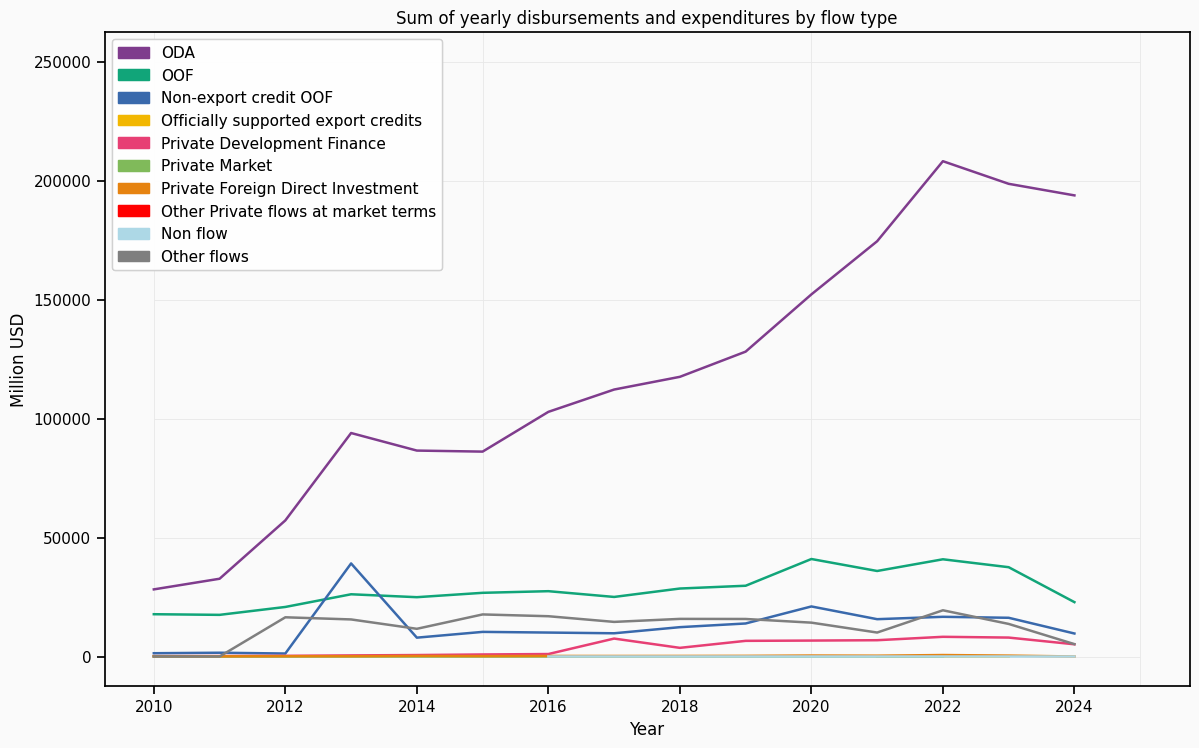

In [20]:
# Initialize layout ----------------------------------------------
fig, ax = plt.subplots(figsize = (14, 8.5))

# Background color
fig.patch.set_facecolor(GREY98)
ax.set_facecolor(GREY98)

# Vertical lines used as scale reference
for h in VLINES:
    ax.axvline(h, color=GREY91, lw=0.6, zorder=0)

# Horizontal lines
ax.hlines(y=np.arange(0, 300000,50000), xmin=2010, xmax=2025, color=GREY91, lw=0.6)

ax.set_xlabel('Year')
ax.set_ylabel('Million USD')
ax.set_title('Sum of yearly disbursements and expenditures by flow type')

#legend
patch1 = mpatches.Patch(color="#7F3C8D", label='ODA')
patch2 = mpatches.Patch(color="#11A579",  label='OOF')
patch3 = mpatches.Patch(color="#3969AC",  label='Non-export credit OOF')
patch4 = mpatches.Patch(color="#F2B701",label = 'Officially supported export credits')
patch5 = mpatches.Patch(color="#E73F74", label='Private Development Finance')
patch6 = mpatches.Patch(color="#80BA5A", label='Private Market')
patch7 = mpatches.Patch(color="#E68310", label='Private Foreign Direct Investment')
patch8 = mpatches.Patch(color="#FF0000", label='Other Private flows at market terms')
patch9 = mpatches.Patch(color="#ADD8E6", label='Non flow')
patch10 = mpatches.Patch(color=GREY50, label='Other flows')

all_handles = (patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8,patch9,patch10)
leg = ax.legend(handles=all_handles)

ax.add_artist(leg)

# Add lines ------------------------------------------------------
for idx, group in enumerate(combined_plot["comb_flowtype_code"].unique()):
    data = combined_plot[combined_plot["comb_flowtype_code"] == group]
    color = COLOR_SCALE[idx]
    print(group, color)
    ax.plot("year", "usd_mil", color=color, lw=1.8, data=data)


In [21]:
!rm -rf dispexpvsflow_plot.xlsx

combined_plot.to_excel("dispexpvsflow_plot.xlsx",sheet_name="dispexpvsflow", index=False)